In [143]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.table import Table
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u


from scipy.stats import ks_2samp

from scipy import stats

## 1. Read distribution sample.

In [144]:
filename = "O4_result/baseline5_widesigmachi2_mass_NotchFilterBinnedPairingMassDistribution_redshift_powerlaw_mag_iid_spin_magnitude_gaussian_tilt_iid_spin_orientation_result_events_baseline5_all.h5"

In [145]:
table = Table.read(filename)
table[:2]

mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_2
float64,float64,float64,float64,float64,float64,float64,float64
1.4003127807104705,0.934954537546301,0.25226035333012586,0.17081800015796333,-0.07445077428355917,0.9653381954834288,1.4144591708724004,1.3092287883093328
1.6007200708910987,0.9777425764328481,0.14350300511641967,0.05476595988100175,0.8604462381564546,0.7046866211743108,1.3044228619425053,1.5650921662608341


## 2. Convert GWTC-4's distribution to suitable format for bayestar-inject

In [146]:

z = table["redshift"]
distance = cosmo.luminosity_distance(z).to_value(u.Mpc)

gwtc4_samples = Table({
    'mass1': table['mass_1'],
    'mass2': table['mass_2'],
    'spin1z': table['a_1'] * table['cos_tilt_1'],
    'spin2z': table['a_2'] * table['cos_tilt_2'],
    'distance': distance 
    })

## 3. Number of events in each sub-population

In [147]:
ns_max_mass = 3
source_mass1 = gwtc4_samples['mass1']
source_mass2 = gwtc4_samples['mass2']

# classify systems

BNS = np.sum((source_mass1 < ns_max_mass) & (source_mass2 < ns_max_mass))
NSBH = np.sum((source_mass1 >= ns_max_mass) & (source_mass2 < ns_max_mass))
BBH = np.sum((source_mass1 >= ns_max_mass) & (source_mass2 >= ns_max_mass))

In [148]:
# print results
print("CBC classification results:")
print(f"  BNS  : {BNS}")
print(f"  NSBH : {NSBH}")
print(f"  BBH  : {BBH}")

CBC classification results:
  BNS  : 740077
  NSBH : 160672
  BBH  : 99251


## GWTC-3 distribustion

In [149]:
gwtc3_samples = Table.read("./data/farah.h5")

gwtc3_samples[:2]

mass1,mass2,spin1z,spin2z
float64,float64,float64,float64
1.6334784673051967,1.3810887548655666,0.0005726141112029242,-0.012026548338777296
2.4116235511053596,2.038928316809099,0.09564577831587825,0.12876640961108698


In [150]:
ns_max_mass = 3
source_mass1 = gwtc3_samples['mass1']
source_mass2 = gwtc3_samples['mass2']

# classify systems

BNS = np.sum((source_mass1 < ns_max_mass) & (source_mass2 < ns_max_mass))
NSBH = np.sum((source_mass1 >= ns_max_mass) & (source_mass2 < ns_max_mass))
BBH = np.sum((source_mass1 >= ns_max_mass) & (source_mass2 >= ns_max_mass))

# print results
print("CBC classification results:")
print(f"  BNS  : {BNS}")
print(f"  NSBH : {NSBH}")
print(f"  BBH  : {BBH}")

CBC classification results:
  BNS  : 892762
  NSBH : 35962
  BBH  : 71276


In [152]:
# gwtc3_samples_bbh = gwtc3_samples[(source_mass1 >= ns_max_mass) & (source_mass2 >= ns_max_mass)]

# len(gwtc3_samples_bbh)

# Internal distribustion BBH

In [134]:
# censor the mass distribution, remove or ovoid a non BBH-astro mass 
def draw_masses(bh_mass_min,  bh_mass_max,  mass_distn, n_samples):
    nbad = n_samples
    mass = np.empty(n_samples)
    bad = np.ones(n_samples, dtype=bool)
    while nbad > 0:
        mass[bad] = mass_distn.rvs(nbad)
        bad = (mass < bh_mass_min) | (mass > bh_mass_max)
        nbad = np.sum(bad)
    return mass

In [135]:
n_samples = 71276 #1000000

# Atrophysique Binaries Black Hole  
# minimal and  max spin
bh_astro_spin_min = -0.99
bh_astro_spin_max = +0.99
bh_mass_min = 5.0
bh_mass_max = 50.0

mass_distn = stats.pareto(b=1.3)
spin_distn = stats.uniform(bh_astro_spin_min, bh_astro_spin_max - bh_astro_spin_min)

# black hole masses
mass1 = draw_masses(bh_mass_min,  bh_mass_max,  mass_distn, n_samples)
mass2 = draw_masses(bh_mass_min,  bh_mass_max,  mass_distn, n_samples)


# swap masses to ensure that mass1 >= mass2 
swap = mass1 < mass2
mass1[swap], mass2[swap] = mass2[swap].copy(), mass1[swap].copy()

# We could simply use this one swap
#mass1, mass2 = np.maximum(mass1, mass2), np.minimum(mass1, mass2)

# black hole spin 
spin1z = spin_distn.rvs(n_samples)
spin2z = spin_distn.rvs(n_samples)


In [136]:
bbh_astro = Table({
                    'mass1' : mass1,
                    'mass2' : mass2,
                    'spin1z': spin1z,
                    'spin2z': spin2z
                    }
                )

bbh_astro[:2]

mass1,mass2,spin1z,spin2z
float64,float64,float64,float64
9.75572715993487,8.927170431492193,0.5007562298808137,-0.42687198212494115
13.724214747448958,8.670897040178996,0.497500480586768,0.42004120788015054


# KS Test

### Use BBH sampling for the test

In [ ]:

# bbh_astro['log10_distance'] = np.log10(bbh_astro['distance'])
# gwtc4_samples['log10_distance'] = np.log10(gwtc4_samples['distance'])

# gwtc4_samples_bbh = gwtc4_samples[(source_mass1 >= ns_max_mass) & (source_mass2 >= ns_max_mass)]

# len(gwtc4_samples_bbh)


71276

In [141]:
# for col in ['mass1', 'mass2', 'spin1z', 'spin2z']:
#     fig, ax = plt.subplots()
#     ax.hist(
#         [bbh_astro[col], gwtc4_samples_bbh[col]],
#         label=['bbh_astro', 'GWTC-4_samples'],
#         histtype='step',
#         density=1,
#         bins=50)
#     ax.set_ylim(0, None)
#     ax.set_ylabel('pdf')
#     ax2 = ax.twinx()
#     ax2.set_ylabel('cdf')
#     ax2.set_ylim(0, 1)
#     ax2.plot(np.sort(bbh_astro[col]), np.linspace(0, 1, len(bbh_astro)), label='bbh_astro')
#     ax2.plot(np.sort(gwtc4_samples_bbh[col]), np.linspace(0, 1, len(gwtc4_samples_bbh)), label='GWTC-4_samples')
#     ax.legend(loc='lower right')
#     ax2.legend(loc='upper right')
#     stat, pvalue = ks_2samp(bbh_astro[col], gwtc4_samples_bbh[col])
#     ax.set_xlabel(col)
#     ax.set_title(f'K-S test statistic={stat:0.3f}, P-value={pvalue:0.3g}')
#     fig.savefig(f'ks_{col}.png', dpi=300)

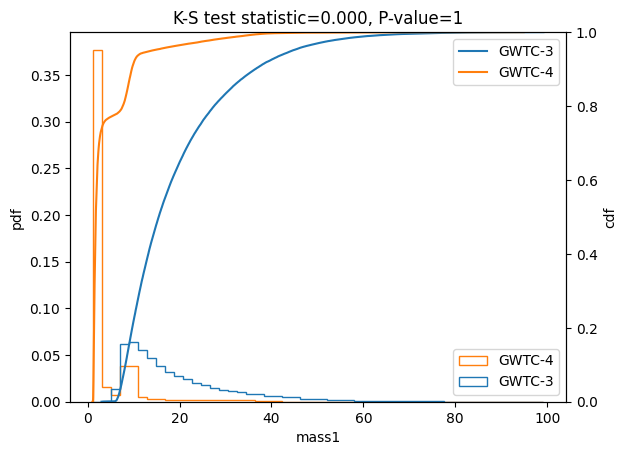

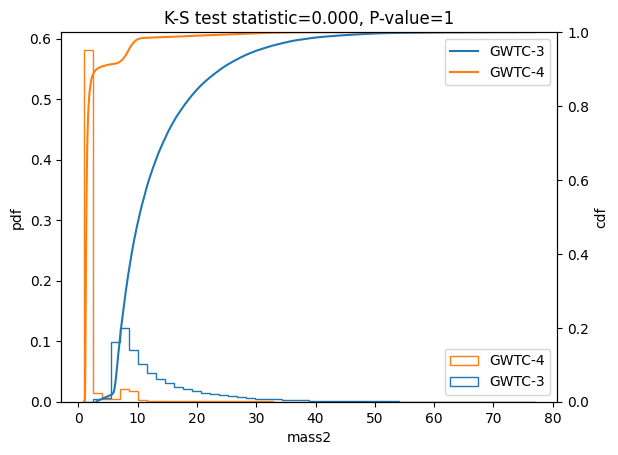

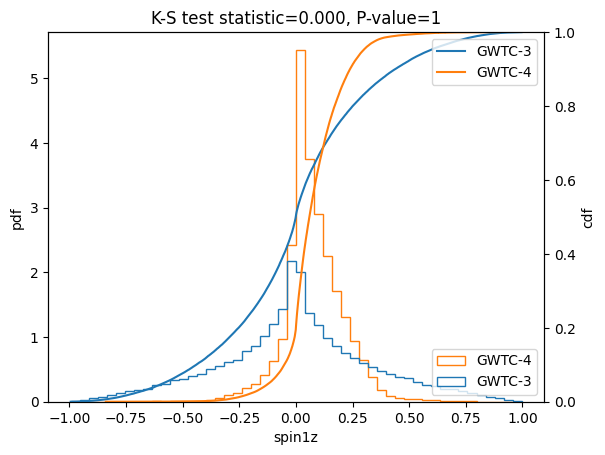

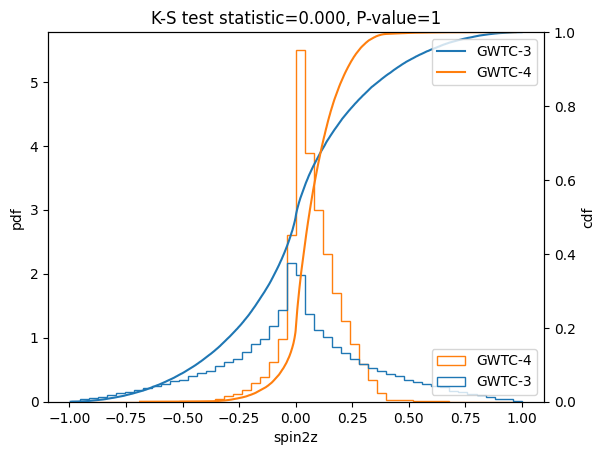

In [ ]:
for col in ['mass1', 'mass2', 'spin1z', 'spin2z']:
    fig, ax = plt.subplots()
    ax.hist(
        [gwtc3_samples[col], gwtc4_samples[col]],
        label=['GWTC-3', 'GWTC-4'],
        histtype='step',
        density=1,
        bins=50)
    ax.set_ylim(0, None)
    ax.set_ylabel('pdf')
    ax2 = ax.twinx()
    ax2.set_ylabel('cdf')
    ax2.set_ylim(0, 1)
    ax2.plot(np.sort(gwtc3_samples[col]), np.linspace(0, 1, len( gwtc4_samples)), label='GWTC-3')
    ax2.plot(np.sort(gwtc4_samples[col]), np.linspace(0, 1, len(gwtc4_samples)), label='GWTC-4')
    ax.legend(loc='lower right')
    ax2.legend(loc='upper right')
    stat, pvalue = ks_2samp(gwtc4_samples[col], gwtc4_samples[col])
    ax.set_xlabel(col)
    ax.set_title(f'K-S test statistic={stat:0.3f}, P-value={pvalue:0.3g}')
    fig.savefig(f'ks_{col}.png', dpi=300)